# Description

It runs a Spectral Clustering (SC) algorithm on the similarity matrix generated by the correlation method specified below (under `Settings`). It saves the set of clustering solutions (called "ensemble") into a pandas dataframe.

# Modules loading

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

from clustermatch import conf
from clustermatch.clustering import generate_ensemble

# Settings

In [2]:
CORRELATION_METHOD_NAME = "clustermatch_k2to5"

In [3]:
# we don't have gene subsets for recount2
# GENE_SELECTION_STRATEGY = "var_pc_log2"

In [4]:
# range of k values that will be used by the clustering algorithm
K_RANGE = [2] + np.arange(5, 100 + 1, 5).tolist() + [125, 150, 175, 200]

In [5]:
# number of times the algorithm will be run for each configuration; it will pick the "best" partition among these, according
# to some internal criteria (see the algorithm's documentation for more information on this parameter, which is `n_init`).
N_INIT = 50

In [6]:
INITIAL_RANDOM_STATE = 12345

In [7]:
def process_similarity_matrix(similarity_matrix):
    """
    It process the similarity matrix to perform any needed adjustment before performing cluster analysis on it.
    """
    # for clustermatch, negative values are meaningless, so we replace them by zero
    similarity_matrix[similarity_matrix < 0.0] = 0.0
    return similarity_matrix

In [8]:
def get_distance_matrix(similarity_matrix):
    """
    It converts the processed similarity matrix into a distance matrix. This is needed to compute some clustering quality measures.
    """
    # the clustermatch coefficient goes from 0 (sometime also negative values that are mean the same as zero) to 1.0
    # the distance is jst 1 minor the coefficient
    return 1.0 - similarity_matrix

# Paths

In [9]:
INPUT_DIR = conf.RECOUNT2["SIMILARITY_MATRICES_DIR"]
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/results/recount2/similarity_matrices')

In [10]:
OUTPUT_DIR = conf.RECOUNT2["CLUSTERING_DIR"]
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
display(INPUT_DIR)

PosixPath('/opt/data/results/recount2/similarity_matrices')

# Setup clustering options

In [11]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_RANGE"] = K_RANGE
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = N_INIT

display(CLUSTERING_OPTIONS)

{'K_RANGE': [2,
  5,
  10,
  15,
  20,
  25,
  30,
  35,
  40,
  45,
  50,
  55,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  100,
  125,
  150,
  175,
  200],
 'KMEANS_N_INIT': 50}

# Get data files

In [12]:
# get input data files according to Settings
input_files = list(INPUT_DIR.glob(f"*-{CORRELATION_METHOD_NAME}.pkl"))
display(len(input_files))
display(input_files)

assert len(input_files) == 1

1

[PosixPath('/opt/data/results/recount2/similarity_matrices/recount_data_prep_PLIER-clustermatch_k2to5.pkl')]

In [13]:
data_file = input_files[0]

## Show the content of one similarity matrix

In [14]:
sim_matrix = pd.read_pickle(data_file)

In [15]:
sim_matrix.shape

(6750, 6750)

In [16]:
sim_matrix.head()

,GAS6,MMP14,DSP,MARCKSL1,SPARC,CTSD,EPAS1,PALLD,PHC2,LGALS3BP,...,LDHB,LDHC,ACAP2,ACAP3,CFL2,CFL1,NFIB,PLEKHG6,GNGT2,SERPINH1
GAS6,1.000000,0.359879,0.161606,0.096449,0.179718,0.241732,0.273178,0.240247,0.222990,0.220751,...,0.059111,0.078427,0.108364,0.251818,0.129664,0.085054,0.106808,0.144849,0.115440,0.255519
MMP14,0.359879,1.000000,0.144209,0.078681,0.271937,0.192011,0.258037,0.207851,0.187494,0.193339,...,0.052428,0.079176,0.089386,0.165300,0.096144,0.079255,0.076691,0.144493,0.123675,0.264664
DSP,0.161606,0.144209,1.000000,0.058510,0.067755,0.067983,0.207457,0.277144,0.066032,0.147427,...,0.028790,0.068707,0.073084,0.084873,0.135008,0.031805,0.161311,0.151766,0.064669,0.312919
MARCKSL1,0.096449,0.078681,0.058510,1.000000,0.041695,0.101608,0.052736,0.068859,0.112262,0.077731,...,0.099796,0.064212,0.112536,0.140569,0.091698,0.131773,0.037773,0.089773,0.076254,0.108979
SPARC,0.179718,0.271937,0.067755,0.041695,1.000000,0.067178,0.123818,0.169873,0.081537,0.117885,...,0.053518,0.033891,0.049880,0.042892,0.128344,0.036825,0.104421,0.039843,0.090324,0.136840


# Clustering

## Generate clusterers

A "clusterer" is an instance of one clustering algorithm with a specified set of parameters. For instance, KMeans with `n_clusters=2` and `random_state=189`.

In [17]:
clusterers = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    clus = SpectralClustering(
        eigen_solver="arpack",
        n_clusters=k,
        n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
        affinity="precomputed",
        random_state=random_state,
    )

    method_name = type(clus).__name__
    clusterers[f"{method_name} #{idx}"] = clus

    random_state = random_state + 1
    idx = idx + 1

In [18]:
display(len(clusterers))

25

In [19]:
_iter = iter(clusterers.items())
display(next(_iter))
display(next(_iter))

('SpectralClustering #0',
 SpectralClustering(affinity='precomputed', eigen_solver='arpack', n_clusters=2,
                    n_init=50, random_state=12345))

('SpectralClustering #1',
 SpectralClustering(affinity='precomputed', eigen_solver='arpack', n_clusters=5,
                    n_init=50, random_state=12346))

In [20]:
clustering_method_name = method_name
display(clustering_method_name)

'SpectralClustering'

## Generate ensemble

In [21]:
# read similarity matrix for this tissue
sim_matrix = pd.read_pickle(data_file)
sim_matrix = process_similarity_matrix(sim_matrix)

In [22]:
# generate ensemble
ensemble = generate_ensemble(
    sim_matrix,
    clusterers,
    tqdm_args={"leave": False, "ncols": 100},
)

In [23]:
# perform some checks on the generate ensemble
# there should be a single k among ensemble partitions
_tmp = ensemble["n_clusters"].value_counts().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == 1

assert not ensemble["n_clusters"].isna().any()

assert ensemble.shape[0] == len(clusterers)

# no partition has negative labels or nan
assert not np.any(
    [np.isnan(part["partition"]).any() for idx, part in ensemble.iterrows()]
)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

# all partitions must have the size of the data
assert np.all(
    [
        part["partition"].shape[0] == sim_matrix.shape[0]
        for idx, part in ensemble.iterrows()
    ]
)

# the number of unique labels in the partition must match the k specified
_real_k_values = ensemble["partition"].apply(lambda x: np.unique(x).shape[0])
assert np.all(ensemble["n_clusters"].values == _real_k_values.values)

In [24]:
# add clustering quality measures
dist_matrix = get_distance_matrix(sim_matrix)

ensemble = ensemble.assign(
    si_score=ensemble["partition"].apply(
        lambda x: silhouette_score(dist_matrix, x, metric="precomputed")
    ),
)

# save
output_filename = f"{data_file.stem}-{clustering_method_name}.pkl"
output_filepath = OUTPUT_DIR / output_filename

ensemble.to_pickle(path=output_filepath)

# Plot cluster quality measures

In [25]:
ensemble.shape

(25, 4)

In [26]:
ensemble.head()

,params,partition,n_clusters,si_score
id,,,,
SpectralClustering #0,"{""affinity"": ""precomputed"", ""assign_labels"": ""...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...",2,0.052160
SpectralClustering #1,"{""affinity"": ""precomputed"", ""assign_labels"": ""...","[0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, ...",5,0.040531
SpectralClustering #2,"{""affinity"": ""precomputed"", ""assign_labels"": ""...","[6, 2, 2, 6, 2, 6, 2, 2, 6, 2, 8, 8, 2, 2, 8, ...",10,0.033564
SpectralClustering #3,"{""affinity"": ""precomputed"", ""assign_labels"": ""...","[3, 3, 12, 7, 9, 11, 12, 12, 11, 3, 9, 3, 3, 1...",15,0.025281
SpectralClustering #4,"{""affinity"": ""precomputed"", ""assign_labels"": ""...","[12, 12, 18, 4, 12, 17, 12, 12, 17, 7, 13, 7, ...",20,0.022367


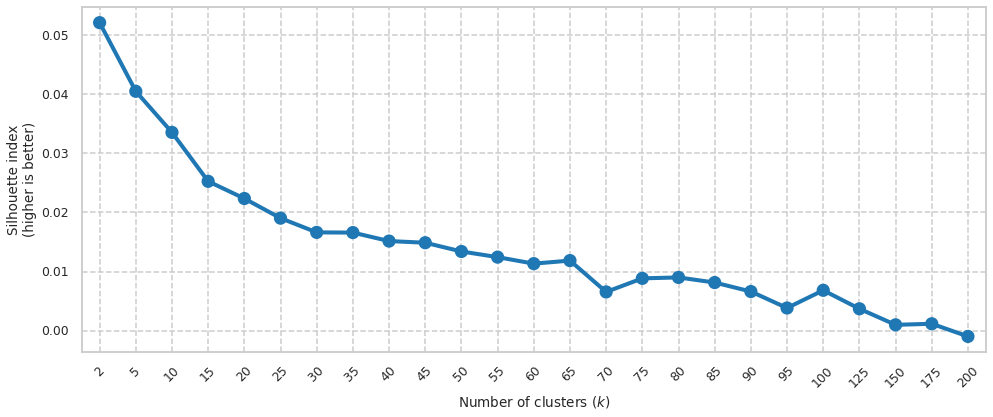

In [27]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))

    ax = sns.pointplot(data=ensemble, x="n_clusters", y="si_score")

    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()
    display(fig)
    plt.close(fig)